### Background

This is a project that came out of a month-long step challenge I organized at my company. I occasionally have difficulty sleeping, and since I would already be wearing my Fitbit 24 hours a day for a month, figured it could be a great opportunity to make a data science project out of it. My goal was to see if I could find any relationship between how active I was throughout the day with how well I slept at night.

### Resources
Before being able to gather my data, I had to create a developer app on the Fitbit website. This [Towards Data Science](https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873) article is an excellent resource for setting that up, so I encourage you to check it out.
ORCAS also created [this Python implementation](https://github.com/orcasgit/python-fitbit) of the Fitbit API which I use to access my data.

### Code

I start by importing the `fitbit` module which I use to make my API calls, and the `gather_keys_oauth2` module for authentication with Fitbit.

In [1]:
import fitbit
from fitbit import gather_keys_oauth2 as Oauth2
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

I'd rather not store my client ID and client secret online for everyone to see (that's all you need to gain access to my app), so I ask for it to be input each time here.

In [ ]:
CLIENT_ID = input('Client ID: ')
CLIENT_SECRET = input('Client Secret: ')

Now I open a browser session and authenticate myself.

In [3]:
server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()

[26/Oct/2019:18:07:54] ENGINE Listening for SIGTERM.
[26/Oct/2019:18:07:54] ENGINE Listening for SIGHUP.
[26/Oct/2019:18:07:54] ENGINE Listening for SIGUSR1.
[26/Oct/2019:18:07:54] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[26/Oct/2019:18:07:54] ENGINE Started monitor thread 'Autoreloader'.
[26/Oct/2019:18:07:54] ENGINE Serving on http://127.0.0.1:8080
[26/Oct/2019:18:07:54] ENGINE Bus STARTED


127.0.0.1 - - [26/Oct/2019:18:07:55] "GET /?code=42777ad6743eeab4a7d7be9ce4b30ee72852a1f9&state=EQWFvgQ2TmHhT9PvX4jsV8Jnrsqleg HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Safari/537.36"


[26/Oct/2019:18:07:56] ENGINE Bus STOPPING
[26/Oct/2019:18:07:56] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[26/Oct/2019:18:07:56] ENGINE Stopped thread 'Autoreloader'.
[26/Oct/2019:18:07:56] ENGINE Bus STOPPED
[26/Oct/2019:18:07:56] ENGINE Bus EXITING
[26/Oct/2019:18:07:56] ENGINE Bus EXITED
[26/Oct/2019:18:07:56] ENGINE Waiting for child threads to terminate...


Once the session is opened, I can get an access token and a refresh token. I then instantiate the actual `Fitbit` class, using all of the access parameters I've gotten.
I also set version 1.2 of the API because I found that has more detailed sleep data.

In [4]:
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2 = True,
                             access_token = ACCESS_TOKEN,
                             refresh_token = REFRESH_TOKEN)
auth2_client.API_VERSION = 1.2

I set a few date related parameters here. The `no_sleep` variable contains the 2 days during the month that I had trouble sleeping, while the `start_date` and `end_date` are used to bracket the API calls I will make.

In [5]:
no_sleep = [pd.Timestamp(2019, 9, 13),
            pd.Timestamp(2019, 9, 22)]

start_date = datetime.datetime(2019, 9, 10)
period = 30
end_date = start_date + datetime.timedelta(days = period)

I can now start pulling in my activity data. I start by creating the empty `activity_level_df` dataframe. I also specify the 3 activity_levels I'm going to look at. There is a fourth level, "sedentary," but any time not spent in one of the other 3 levels was spent sedentary, so I omit it.

In [6]:
activity_level_df = pd.DataFrame()
activity_level = ['LightlyActive', 'FairlyActive', 'VeryActive']

Now I loop through the 3 activity levels, and use the `time_series` method to make calls to the API.

In [7]:
for level in activity_level:
    activity_data = auth2_client.time_series('activities/minutes{}'\
                                             .format(level),
                                             base_date = start_date,
                                             end_date = end_date)
    activity_df = pd.DataFrame(activity_data['activities-minutes{}'.\
                                             format(level)]).\
                                             rename({'value': level},
                                                    axis = 1)
    activity_df[level] = pd.to_numeric(activity_df[level])
    # Need to set_index otherwise columns overlapping creates ValueError
    activity_level_df = activity_level_df.join(activity_df.\
                                               set_index('dateTime'),
                                               how = 'outer')

This is a little bit of clean up to make the dataframe easier to join further down.

In [8]:
activity_level_df = activity_level_df.reset_index()
activity_level_df['dateTime'] = pd.to_datetime(activity_level_df['dateTime'])

Let's take a look at what my activity level dataframe looks like. Very simple - it contains the dates and how many minutes I was active at each level.

In [9]:
activity_level_df.head()

,dateTime,LightlyActive,FairlyActive,VeryActive
0,2019-09-10,162,26,148
1,2019-09-11,224,36,41
2,2019-09-12,244,97,94
3,2019-09-13,238,45,50
4,2019-09-14,304,32,65


I now move on to gathering my sleep data. Once again, I start by creating an empty `sleep_summary_df` dataframe.

In [10]:
sleep_summary_df = pd.DataFrame()

Here, I use the `time_series` method again, this time to access my sleep data. Unlike the activity data, I don't need to specify any separate levels or stages, so it's only this one single call.

In [11]:
sleep_data = auth2_client.time_series('sleep',
                                      base_date = start_date,
                                      end_date = end_date)

The sleep data comes through as one large JSON object. Here's an idea of how much information it contains. (It's a lot!)

In [12]:
sleep_data['sleep'][0]

{'dateOfSleep': '2019-10-10',
 'duration': 23760000,
 'efficiency': 97,
 'endTime': '2019-10-10T05:28:30.000',
 'infoCode': 0,
 'isMainSleep': True,
 'levels': {'data': [{'dateTime': '2019-10-09T22:52:00.000',
    'level': 'light',
    'seconds': 1140},
   {'dateTime': '2019-10-09T23:11:00.000', 'level': 'deep', 'seconds': 300},
   {'dateTime': '2019-10-09T23:16:00.000', 'level': 'light', 'seconds': 1440},
   {'dateTime': '2019-10-09T23:40:00.000', 'level': 'deep', 'seconds': 450},
   {'dateTime': '2019-10-09T23:47:30.000', 'level': 'light', 'seconds': 1530},
   {'dateTime': '2019-10-10T00:13:00.000', 'level': 'rem', 'seconds': 900},
   {'dateTime': '2019-10-10T00:28:00.000', 'level': 'light', 'seconds': 1140},
   {'dateTime': '2019-10-10T00:47:00.000', 'level': 'deep', 'seconds': 570},
   {'dateTime': '2019-10-10T00:56:30.000', 'level': 'light', 'seconds': 540},
   {'dateTime': '2019-10-10T01:05:30.000', 'level': 'deep', 'seconds': 1740},
   {'dateTime': '2019-10-10T01:34:30.000', 'le

Note that this is the **first** entry in the JSON object, but the **last** day in our range. Therefore, I loop through all of the sleep entries in reverse order and pull out "summary", "efficiency" and also make note of any nights I fell asleep after 11:00 PM (23h00). I usually try to turn out my light by 10:30 PM (22h30) at the latest, so any nights I fell asleep after 11:00 PM might clue me in to something that was keeping me up.

In [13]:
for date in sleep_data['sleep'][::-1]:
    # Minutes in each stage
    sleep_df = pd.DataFrame(date['levels']['summary']).loc['minutes']
    # Sleep efficiency
    sleep_df = sleep_df.append(pd.Series(date['efficiency']).\
                               rename({0: 'efficiency'}))
    # Check if asleep before 11 (1 if True, 0 if False)
    asleep_time = pd.to_datetime(date['startTime']).time()
    sleep_df = sleep_df.append(pd.Series(
                             int(asleep_time < datetime.time(23, 00, 00) and \
                                 asleep_time > datetime.time(4, 00, 00))).\
                             rename({0: 'before_11'}))
    minutes_data = pd.Series(sleep_df.rename(date['dateOfSleep']))
    sleep_summary_df = sleep_summary_df.append(minutes_data)

From Fitbit's website, sleep "efficiency" is defined as:

$$\frac{Time\ Asleep}{Total\ Time\ in\ Bed\ -\ Time\ to\ Fall\ Asleep}$$

This is a bit of an odd calculation - imagine I'm having trouble falling asleep so I get up and pace around a bit. This isn't considered "time in bed", which might artificially inflate this score. Alternatively, imagine I'm in bed, sitting up reading until I'm basically asleep sitting up, then turn out my light. At what point does Fitbit start tracking my "time to fall asleep"? If it's the moment when I turn out my light, then it will be very close to 0 (since I'm waiting until I'm already basically asleep sitting up), which will once again artificially inflate this number.

The point is, this might not be the most perfect value to look in a vacuum, so it is important to take all of our data together to get an idea of what's happening.

Here I do a little bit of clean up on the dataframe. Note the last command which subtracts one day from each of the days in the `dateTime` column. Fitbit reports the `dateOfSleep` as the date I wake up, **not** the date I fall asleep. Since I am interested in how my activity levels affect my sleep at night, by subtracting one day here I ensure the dataframes will match up when joined.

In [14]:
sleep_summary_df = sleep_summary_df[['efficiency', 'wake', 'light', 'deep',
                                     'rem', 'awake', 'restless', 'asleep',
                                     'before_11']]
sleep_summary_df = sleep_summary_df.reset_index().\
                                   rename({'index':'dateTime'}, axis = 1)
sleep_summary_df['dateTime'] = pd.to_datetime(sleep_summary_df['dateTime'])
# Fitbit refers to the night of sleep by the date of the morning you wake up
sleep_summary_df['dateTime'] = sleep_summary_df['dateTime'].apply(
                               lambda x: x - datetime.timedelta(days = 1))

Let's take a look at what my sleep summary dataframe now looks like.

In [15]:
sleep_summary_df.head()

,dateTime,efficiency,wake,light,deep,rem,awake,restless,asleep,before_11
0,2019-09-10,97.0,59.0,186.0,42.0,72.0,NaN,NaN,NaN,0.0
1,2019-09-11,96.0,55.0,195.0,78.0,102.0,NaN,NaN,NaN,1.0
2,2019-09-12,94.0,36.0,223.0,64.0,78.0,NaN,NaN,NaN,1.0
3,2019-09-13,94.0,NaN,NaN,NaN,NaN,10.0,19.0,407.0,0.0
4,2019-09-14,96.0,41.0,237.0,71.0,106.0,NaN,NaN,NaN,1.0


If Fitbit can't track my heart rate during the night, it can't assign a sleep stage to it, hence the "awake", "restless", "asleep" columns of mostly NaN's. This only happened twice during the month, so I think I can drop these columns (instead of carrying a bunch of NaN's through) and not lose much data. The data doesn't match up well with any of the other columns either, so it's not particularly useful.

Now I join the 2 dataframes, dropping the columns as mentioned above. I need to set the index of the `sleep_summary_df` to `dateTime` so that I can perform the join operation on that column.

In [16]:
df = activity_level_df.join(sleep_summary_df.drop(
                            columns = ['asleep', 'awake', 'restless']).\
                            set_index('dateTime'),
                            on = 'dateTime')

In [17]:
df.head()

,dateTime,LightlyActive,FairlyActive,VeryActive,efficiency,wake,light,deep,rem,before_11
0,2019-09-10,162,26,148,97.0,59.0,186.0,42.0,72.0,0.0
1,2019-09-11,224,36,41,96.0,55.0,195.0,78.0,102.0,1.0
2,2019-09-12,244,97,94,94.0,36.0,223.0,64.0,78.0,1.0
3,2019-09-13,238,45,50,94.0,NaN,NaN,NaN,NaN,0.0
4,2019-09-14,304,32,65,96.0,41.0,237.0,71.0,106.0,1.0


Note the index in the dataframe gets reset to just a row number, despite setting it to the `dateTime` column above. This is actually what I want when I go to plot this dataframe. Since bar plots are categorical, while line plots are discrete, I can't actually use the `dateTime` column to plot my activity levels (as a bar plot) and sleep stages (as a line plot) directly. Instead, I plot the dataframe as is and change the x-labels afterwards.

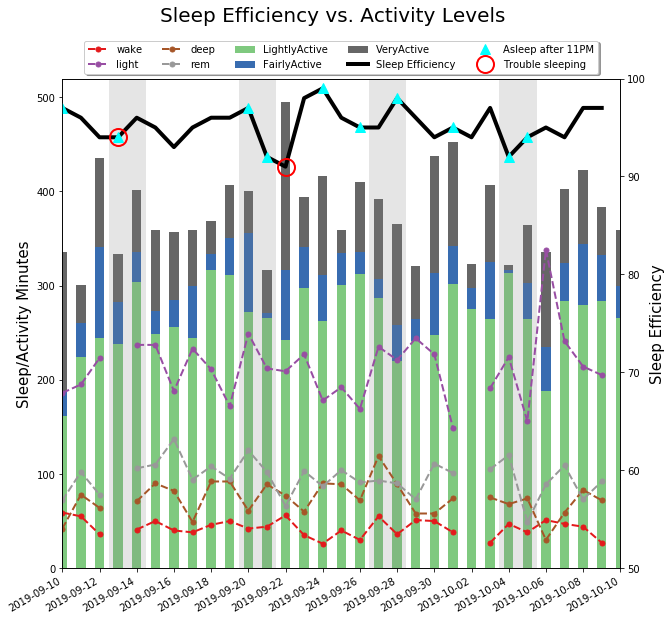

In [18]:
fig, ax1 = plt.subplots(figsize = (10, 10))
fig.suptitle('Sleep Efficiency vs. Activity Levels',
             fontsize = 20)
ax2 = plt.twinx(ax = ax1)
df[['LightlyActive', 'FairlyActive', 'VeryActive']].plot(ax = ax1,
                                                         kind = 'bar',
                                                         stacked = True,
                                                         cmap = 'Accent')
df[['wake', 'light', 'deep', 'rem']].plot(ax = ax1,
                                          linewidth = '2',
                                          linestyle = '--',
                                          marker = '.',
                                          markersize = 10,
                                          cmap = 'Set1')
# Shade weekends
for i, day in enumerate(df['dateTime']):
    if day.weekday() / 4 == 1:
        ax1.axvspan(i - 0.5, i + 1.5,
                    facecolor = 'gray',
                    alpha = 0.2)
date_range = pd.date_range(start_date - datetime.timedelta(days = 2),
                           end_date,
                           freq = '2D')
ax1.set_xticklabels(pd.Series(date_range).apply(lambda x: x.date()))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.set_ylabel('Sleep/Activity Minutes', fontsize = 15)
df['efficiency'].plot(ax = ax2,
                      linewidth = '4',
                      color = 'k',
                      label = 'Sleep Efficiency')
# Plot markers where asleep after 11
df[df['before_11'] == 0]['efficiency'].plot(kind = 'line',
                                            marker = '^',
                                            markersize = 10,
                                            linestyle = 'none',
                                            color = 'cyan',
                                            label = 'Asleep after 11PM')
# Plot markers where unable to fall asleep
df[df['dateTime'].isin(no_sleep)]['efficiency'].\
                                  plot(kind = 'line',
                                  marker = 'o',
                                  markersize = 17,
                                  fillstyle = 'none',
                                  linestyle = 'none',
                                  color = 'red',
                                  markeredgewidth = 2,
                                  label = 'Trouble sleeping')

ax2.set_ylim(50, 100)
ax2.set_ylabel('Sleep Efficiency', fontsize = 15)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2,
           labels_1 + labels_2,
           loc = 'lower center',
           bbox_to_anchor = (0.5, 1.0),
           ncol = 5,
           fancybox = True,
           shadow = True)
fig.autofmt_xdate()
plt.show()

Voila! My activity levels are shown in the bar plot, sleep stages in the dashed line plot, and sleep efficiency in the solid black. Red circles indicate nights I was unable to fall asleep or woke up and couldn't fall back asleep.
Unfortunately, it doesn't look like my daily activity output has much impact on how well I sleep at night, at least for these 2 data points. On 9/13, I was roughly active an average amount throughout the day, but couldn't fall asleep. On 9/22, I was the most active I had been all month, but woke up and then couldn't fall back asleep. It's possible if I ran this experiment for more time I might find a relationship, but the step challenge ended and I wanted to go back to wearing normal watches.
Also, it's worth it to note that there are many other things unrelated to activity output (e.g. stress throughout the day) that could affect my sleep which Fitbit does not capture.